# Fraud Detection 
This notebook will attempt to build a predictive algorithm to detect a fraudulent transaction using a training dataset. We will explain the thinking process at every step using LIME (Local Interpretable Model-agnostic Explanations) principles making it accessible and user-friendly.


## Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statitics
    * Target Variable Analysis
    * Predictors Analysis
3. Data Cleaning
    * Missing Values
    * Outliers
    * Duplicate Observations
4. Correlation Analysis
    * Correlation Matrix
    * Strongest relationship
5. Inquiry Exploration
    * How does Amount's distribution behaves across classes?
    * Are there any noteworthy point in time where fraud occured?
6. Class Imbalance 
    * SMOTE - Synthetic Minority Oversampling Technique
    * Near-Miss Algorithm
    * Combined Random Sampler
7. Machine Learning set-up
    * Train-test split
    * Cross-validation
8. Dimensionality Reduction
    * PCA - Principal Component Analysis
    * SVD - Singular Value Decomposition
    * LDA - Linear Discriminant Analysis
9. Machine Learning - Simple Models
    * Logistic Regression
    * k-Nearest Neighbors
    * Decision Tree
    * Stochastic Gradient Descent
10. Machine Learning - Ensemble Methods
    * Random Forest
    * Stochastic Gradient Boosting
    * StackingClassifier
11. Hyperparameter Tuning
    * Random Search
    * Grid Search
12. Model Performance Evaluation
    * Final Model
    * AUC - ROC Curve

# 1. Environment Set-up

In [1]:
## Importing libraries
set.seed(1)
library(dplyr)
library(tidyverse)
library(ggplot2)

library(ROSE)
library(corrplot)

library(e1071)
library(caret)
library(rpart)

library(gmodels)
library(glmnet)

library(MLmetrics)
require(MASS)
library(PRROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ stringr 1.4.0
✔ tidyr   1.1.4     ✔ forcats 0.5.1
✔ readr   2.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loaded ROSE 0.0-3


corrplot 0.88 loaded

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1


Attaching package:

In [2]:
## Loading dataset
df <- read_csv(file = '/kaggle/input/creditcardfraud/creditcard.csv')

Rows: 284807 Columns: 31

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (31): Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



# 2. Initial Diagnostics

In [3]:
## Glimpse of the data
df %>% head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [4]:
## Descriptive Statistics
df %>% summary()

      Time              V1                  V2                  V3          
 Min.   :     0   Min.   :-56.40751   Min.   :-72.71573   Min.   :-48.3256  
 1st Qu.: 54202   1st Qu.: -0.92037   1st Qu.: -0.59855   1st Qu.: -0.8904  
 Median : 84692   Median :  0.01811   Median :  0.06549   Median :  0.1799  
 Mean   : 94814   Mean   :  0.00000   Mean   :  0.00000   Mean   :  0.0000  
 3rd Qu.:139320   3rd Qu.:  1.31564   3rd Qu.:  0.80372   3rd Qu.:  1.0272  
 Max.   :172792   Max.   :  2.45493   Max.   : 22.05773   Max.   :  9.3826  
       V4                 V5                   V6                 V7          
 Min.   :-5.68317   Min.   :-113.74331   Min.   :-26.1605   Min.   :-43.5572  
 1st Qu.:-0.84864   1st Qu.:  -0.69160   1st Qu.: -0.7683   1st Qu.: -0.5541  
 Median :-0.01985   Median :  -0.05434   Median : -0.2742   Median :  0.0401  
 Mean   : 0.00000   Mean   :   0.00000   Mean   :  0.0000   Mean   :  0.0000  
 3rd Qu.: 0.74334   3rd Qu.:   0.61193   3rd Qu.:  0.3986   3rd Qu

**Takeaway:** The following percentage breakdown confirms the note in the project description; indeed, we have a considerable class imbalance with the target variable. It stays consistent that most fraudulent activities are much less frequent than non-fraudulent. Before proceeding, we shall note it to avoid any overfitting issues when fitting the machine learning models.

In [5]:
## Target Variable Analysis
df %>% group_by(Class) %>%
  summarise(cnt = n()) %>%
  mutate(freq = round(cnt / sum(cnt), 5)) %>% 
  arrange(desc(freq))

Class,cnt,freq
<dbl>,<int>,<dbl>
0,284315,0.99827
1,492,0.00173


**Note:** We did not have any information on the numerical predictors for privacy, given their transformation and standardization, excluding Amount & Time. In that regard, Amount presented itself as potentially most informative for the feature variable analysis. To better understand the variable's distribution, we had to transform it using a log scale.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     5.60    22.00    88.35    77.17 25691.16 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1825 rows containing non-finite values (stat_bin).”


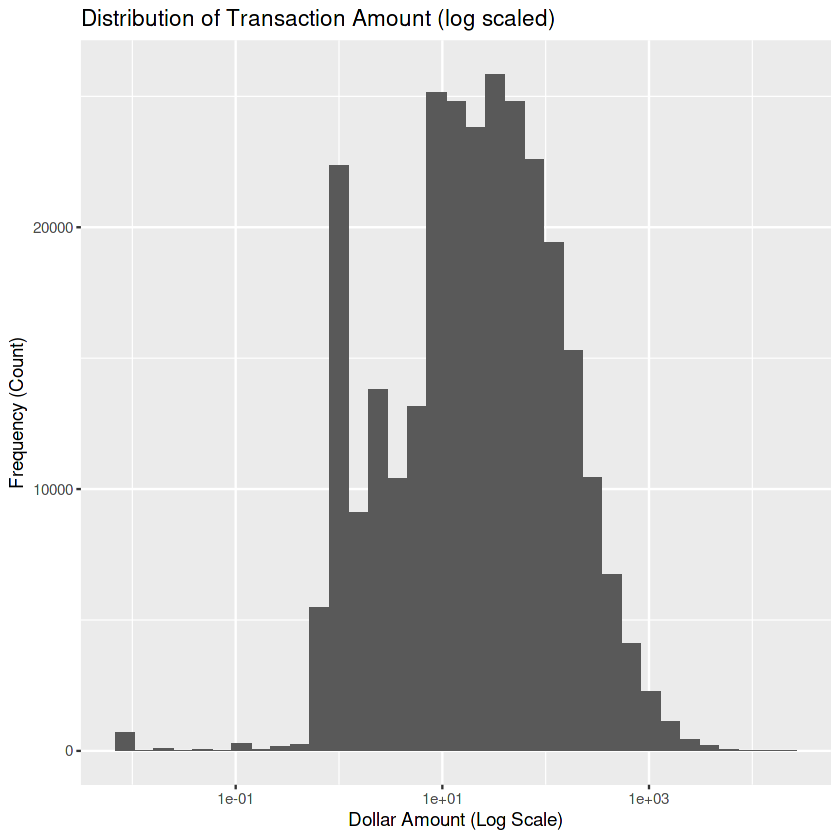

In [6]:
## Target Variable Analysis
df$Amount %>% summary()

df %>% ggplot(aes(Amount)) +
  geom_histogram(bins=35) +
  scale_x_log10() +
  labs(
  x = "Dollar Amount (Log Scale)",
  y = "Frequency (Count)",
  title= "Distribution of Transaction Amount (log scaled)"
 )

# 3. Data Cleaning

In [7]:
## Missing Values
df %>% is.na() %>% sum()

[1] 0

**Takeaway:** As the count shows, we have no missing values given the pre-processing done prior.

**Note:** With most predictors transformed, there will be little chance for any outliers in the data points for V1, V2, ..., V28. So, we will only examine Amount as the only meaningful numeric feature.

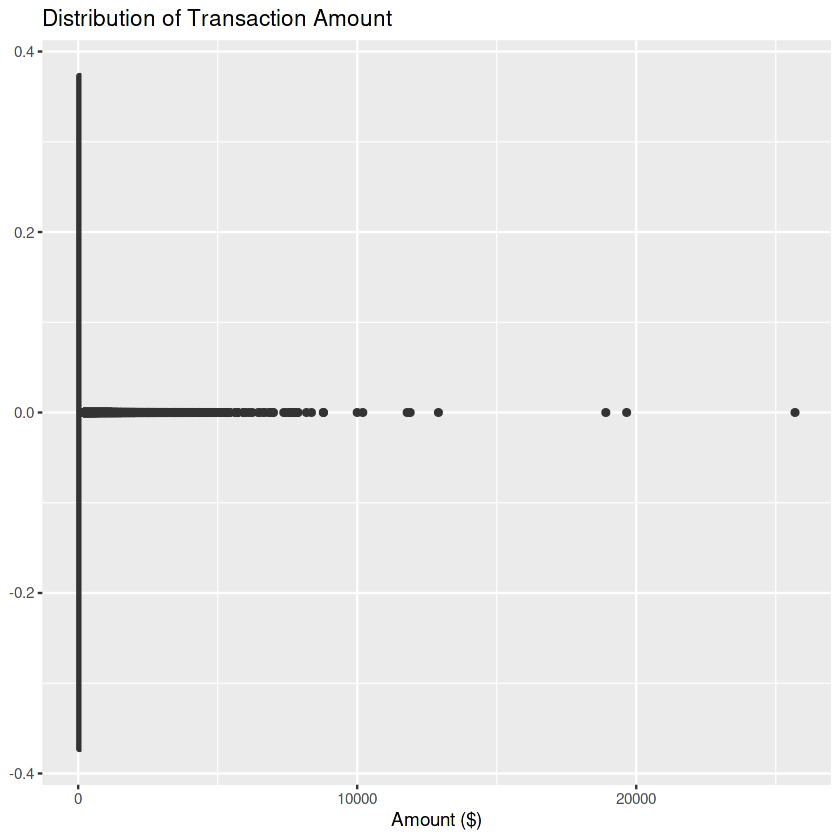

In [8]:
df %>% ggplot(aes(x=Amount)) +
  geom_boxplot() +
  labs(
  x = "Amount ($)",
  title= "Distribution of Transaction Amount"
 )

**Takeaway:** From the boxplot below, we can observe a non-negligible number of outliers on the upper end of the distribution. It would denote transactions with high amounts in the order of thousands of dollars. We would assess the effect of this skewed distribution when building the predictive models in terms of feature transformation or selecting models robust to such feature types.

In [9]:
df %>% duplicated() %>% sum()

[1] 1081

**Takeaway:** A quick check reveals 1081 duplicate rows, so we proceed in removing them from the dataset.

In [10]:
df <- df[!duplicated(df), ]

**Definition:** Feature Engineering

In [11]:
df$Amount <- scale(df$Amount)

# 4. Correlation Analysis

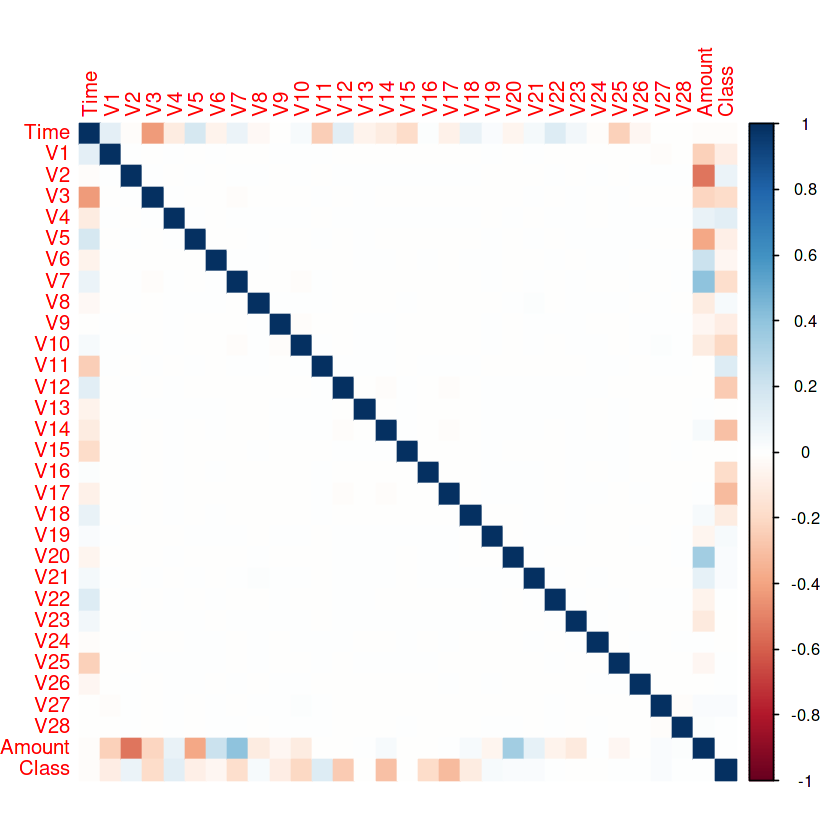

In [12]:
df_cor <- cor(df)
corrplot(df_cor, method = 'color')

**Takeaway:** From the correlation matrix plotted, we can observe very few correlated variables as we would expect after the feature transformation. The two meaningful features, are Time and Amount, have some relative correlation with some variables with coefficients approximating 0.4. With such low values, it would be pretty challenging to imply a correlation between any of them with any certainty. It also indicates that there would be a very low incidence of any colinearity within our data

**Note:** The code below filters those pairs with correlation coefficients above 0.5 as a threshold. As noted above, those values give very little to no confidence in any solid correlated relationship between variables as few crossing the 0.5 mark.

In [13]:
df_cor <- as.data.frame(df_cor)
df_cor[(abs(df_cor) >= 0.5) & (abs(df_cor) !=1)]

[1] -0.533428 -0.533428

# 5. Inquiry Exploration

**Note:** In an attempt to answer the first question, we first split our dataset by class types; in other words, fraudulent and non-fraudulent transactions. We then plot the histogram side by side to observe any unusual behavior. In doing so, the non-fraud transactions were heavily right-skewed, making it quite challenging to compare the plots. To solve this issue, we used a logarithmic transformation, making it easier to see and thus, evaluate any similarities and differences.

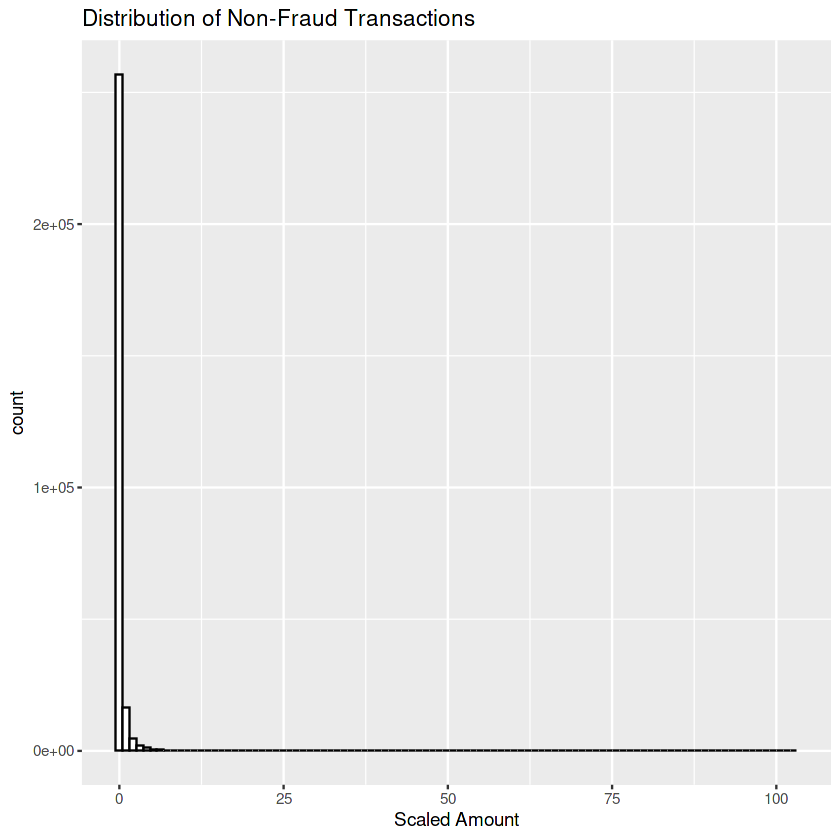

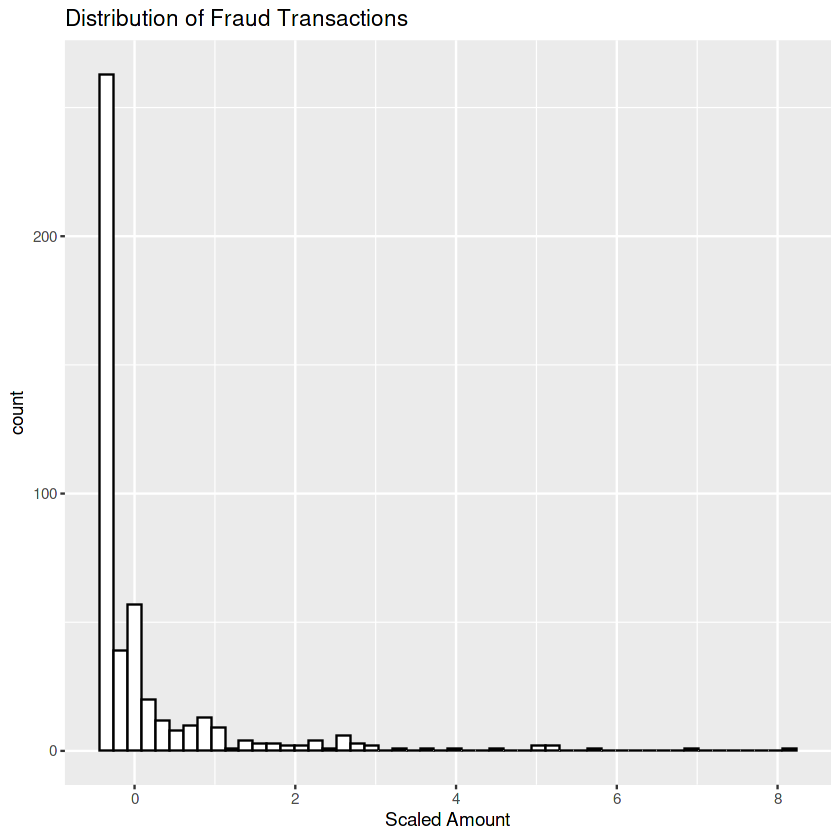

In [14]:
# How does Amount's distribution behaves across classes?

# Splitting data by fraud class
df_no_fraud <- df %>% filter(Class == 0)
df_fraud <- df %>% filter(Class == 1)

# Histogram for Amount Distribution per class
df_no_fraud %>% ggplot(aes(x=Amount)) +
  geom_histogram(color="black", fill="white", bins=100) +
  labs(
  x = "Scaled Amount",
  title= "Distribution of Non-Fraud Transactions"
 )

df_fraud %>% ggplot(aes(x=Amount)) +
  geom_histogram(color="black", fill="white", bins=50) +
  labs(
  x = "Scaled Amount",
  title= "Distribution of Fraud Transactions"
 )

**Takeaway:** Before making a note on the plots, we will first explain how to interpret logarithmic scales. In short, log scales show relative values rather than absolute ones. Indeed, 2 minus 1 would be displayed similarly to 9999 minus 9998, given that we are dealing with percentages here. In context, the histograms below would depict the order of growth of transaction value. Both distributions represent a similar trajectory, with most transactions on the lower end of the graph. It stays consistent with the mean value found at USD88, even with max values averaging USD20,000.

**Note:** For the second question, we will check the timing of transactions to detect anything unusual. We will use only the fraud dataset and plot a scatterplot accordingly.

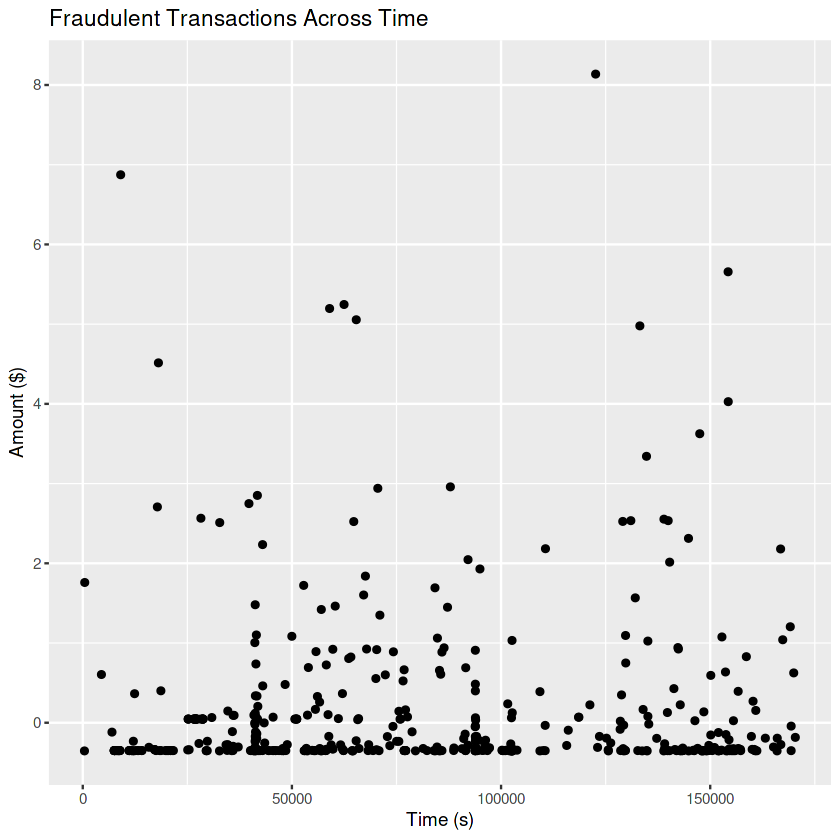

In [15]:
## Are there any noteworthy point in time where fraud occured?
# Scatterplot
df_fraud %>% ggplot(aes(x=Time, y=Amount)) +
  geom_point() +
  labs(
  y = "Amount ($)", 
  x = "Time (s)",
  title= "Fraudulent Transactions Across Time"
 )

**Takeaway:** The graph above does not appear that there is a clustering pattern on a time interval. So, we would assume that fraud occurred across time quite randomly.

# 6. Class Imbalance

**Note:** Our diagnostics observed a stark imbalance between classes of transactions, with fraud only making up 0.2% of all transaction statuses. Given the limited pool of examples to train, it poses an issue in terms of building an effective machine model to predict if there is a fraud. With the minority class being so small, we would expect poor performance on the critical task of detecting fraud transactions. In that vein, we will use different sampling methods (Undersampling & Oversampling) to tackle this problem.

**Definition:** SMOTE (Synthetic Minority Oversampling Technique) is an oversampling approach to the minority class. In context, it would mean to randomly increase fraud examples by "artificially" replicating to have a more balanced class distribution. Further information [here](https://rikunert.com/smote_explained).

In [16]:
## now using ROSE for oversampling
ROSE_over <- ovun.sample(Class ~., data=df,
                                  p=0.5, seed=1,
                                  method="over")

In [17]:
data_balanced_over <- ROSE_over$data

## Check class distribution after using SMOTE
data_balanced_over %>% group_by(Class) %>%
  summarise(cnt = n()) %>%
  mutate(freq = round(cnt / sum(cnt), 5)) %>% 
  arrange(desc(freq))

Class,cnt,freq
<dbl>,<int>,<dbl>
1,283545,0.50026
0,283253,0.49974


**Definition:** We proceed to an undersampling approach on the majority class. In context, we select examples to keep out of the training set based on the distance of majority class examples to minority class examples.

In [18]:
## now using ROSE for oversampling
ROSE_under <- ovun.sample(Class ~., data=df,
                                  p=0.5, seed=1,
                                  method="under")

data_balanced_under <- ROSE_under$data

In [19]:
## Check class distribution after using SMOTE
data_balanced_under %>% group_by(Class) %>%
  summarise(cnt = n()) %>%
  mutate(freq = round(cnt / sum(cnt), 5)) %>% 
  arrange(desc(freq))

Class,cnt,freq
<dbl>,<int>,<dbl>
1,473,0.5097
0,455,0.4903


**Note:** With the risk of overfitting with oversampling and the possibility of losing valuable information from undersampling, we understand that we cannot have a perfect solution to this class imbalance problem. In that vein, we shall proceed with the oversampling approach by building robust models to avoid overfitting.

In [20]:
df <- data_balanced_over

# 7. Machine Learning set-up

Under this section, we will explain the procedure of two main splitting approach to estimate our models' performance.

**Definition**: Often denoted as the most popular by its simplicity, the train-test split is a sampling technique dividing the dataset between training and testing sets. In doing so, the goal would be to have enough (but not too much) in our training set used for the machine learning model to predict the observations in the testing set as accurately as possible. Most would opt for a 70/30 training-testing split, respectively, others 80/20, 60/40, or whichever else works best for the case scenario. Further information [here](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/).

In [21]:
# Setting Target Variable to categorical
df$Class <- as.factor(df$Class)

In [22]:
## Training Testing Split
N <- nrow(df)
trainingSize  <- round(N*0.7)
trainingCases <- sample(N, trainingSize)
train <- df[trainingCases,]
test <- df[-trainingCases,]

In [23]:
# Building tree model
tree <- rpart(Class ~ ., data = train, method = "class")

# Making predictions
pred <- predict(tree, train, type="class")
obs <- train$Class
acc <- 1-sum(pred != obs)/nrow(train)
acc

[1] 0.9346606

**Definition:** As the name would suggest, we will engage here in the process of validation to ensure reliability on our model. Cross-Validation is a statistical method applied in various ways to estimate the model's performance. Some examples are Holdout Method, K-Fold, Stratified K-Fold, Leave-P-Out. Further information [here](https://machinelearningmastery.com/k-fold-cross-validation/) and [here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f).

**Note:** As we already tackled the issue of class imbalance with a combination of under- and over-sampling, we will use the K-Fold cross-validation

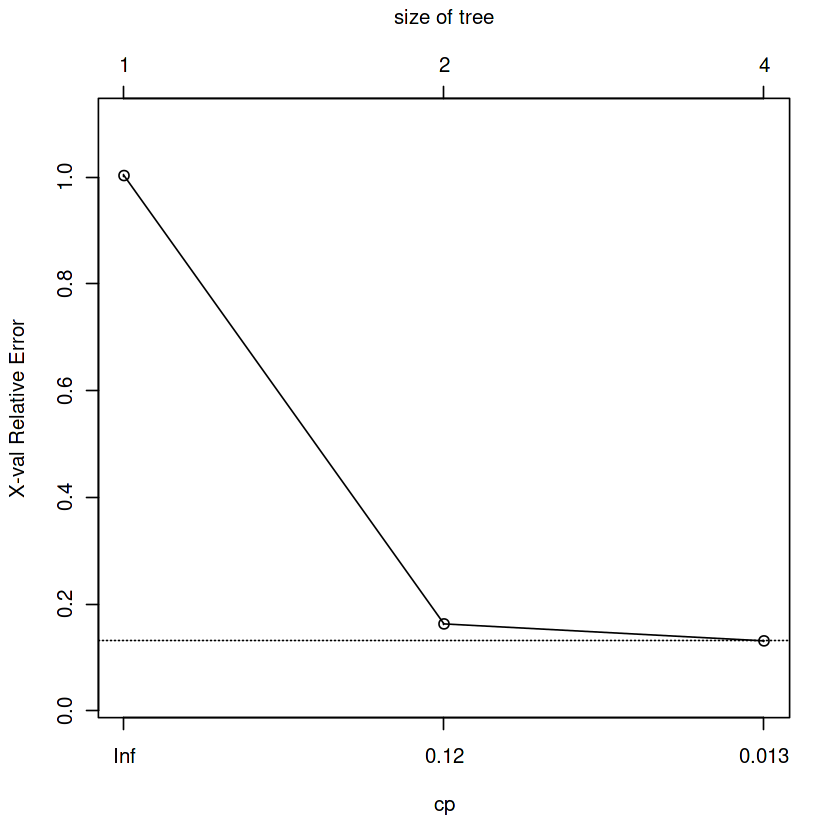

In [24]:
# K-fold cross-validation 
# Building tree model
tree_cv <- rpart(Class ~ ., data = train,
              method = "class", control = rpart.control(xval=5))
plotcp(tree_cv)

# 8. Dimensionality Reduction

This section will use dimensionality reduction to trim down the number of features we have. Dimensionality reduction encapsulates the techniques reducing the input variables in our training data. In doing so, we hope to have a more straightforward but effective machine learning model structure and avoid any potential case of overfitting. We will be testing three different methods from Linear Algebra: PCA, SVD, and LDA and pick the one capturing the most variability in the datasets after reducing it to principal components. We performed the evaluation and comparison process using the following [code](https://rpubs.com/JanpuHou/278584) from Janpu Hou on their RPubs blogs.

In [25]:
# Seperating features from target variable
X <- subset(df, select = -c(Class))

In [26]:
# Function to check Variance explained
pcaCharts <- function(x) {
    x.var <- x$sdev ^ 2
    x.pvar <- x.var/sum(x.var)
    print("proportions of variance:")
    print(x.pvar)
    
    par(mfrow=c(2,2))
    plot(x.pvar,
         xlab="Principal component", 
         ylab="Proportion of variance explained", 
         ylim=c(0,1), type='b')
    plot(cumsum(x.pvar),
         xlab="Principal component", 
         ylab="Cumulative Proportion of variance explained", 
         ylim=c(0,1), type='b')
    screeplot(x)
    screeplot(x,type="l")
    par(mfrow=c(1,1))
}

**Definition:** PCA (Principal Component Analysis) takes data with m-columns projected to a subspace with n-features (n < m) while preserving the crucial information from the original data; in other words, PCA attempts to find the principal components (or features) as its names denote. Further information [here](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/).

Warning message in as.data.frame.numeric(pca_var, n_pc):
“'row.names' is not a character vector of length 30 -- omitting it. Will be an error!”


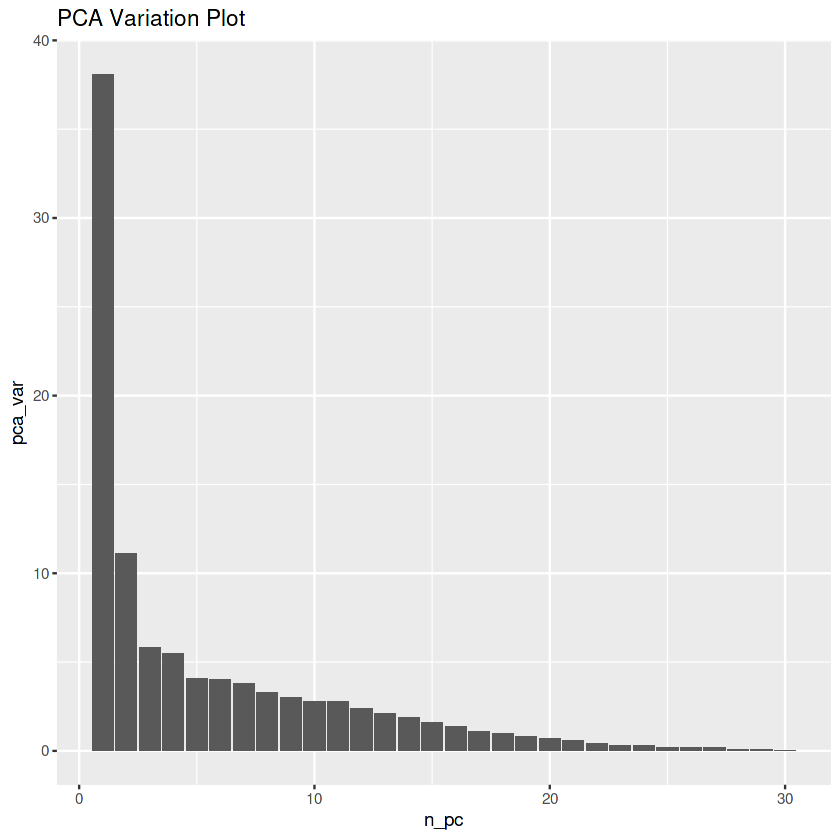

In [27]:
pca <- prcomp(X, scale. = TRUE)
# pcaCharts(pca)

# Calculate Explained Variance
pca_var <- round((pca$sdev^2)/sum(pca$sdev^2) * 100, 1) 
n_pc <- seq(1, length(pca_var))
pca_df <- as.data.frame(pca_var, n_pc)

# Graph of explained variance
pca_df %>% 
  ggplot(aes(x = n_pc, y = pca_var)) +
    geom_bar(stat = 'identity') +
    labs(title = "PCA Variation Plot",
         xlab = "PCs",
         ylab = "Prop. of variance explained",
         ylim = c(0, 100))

**Takeaway:** Beyond 5, there is very little improvement in the explained variance for the PCA.

**Definition:** SVD (Singular Value Decomposition) is a process breaking down a matrix into its constituents elements by factorizing it into three separate matrices: M=UΣVᵗ.

M: original matrix

U: left singular matrix (columns are left singular vectors) containing eigenvectors of matrix MMᵗ

Σ: a diagonal matrix containing singular (eigen)values

V: right singular matrix (columns are right singular vectors) containing eigenvectors of matrix MᵗM.

Further information [here](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/).

Warning message in as.data.frame.numeric(svd_var, n_pc):
“'row.names' is not a character vector of length 30 -- omitting it. Will be an error!”


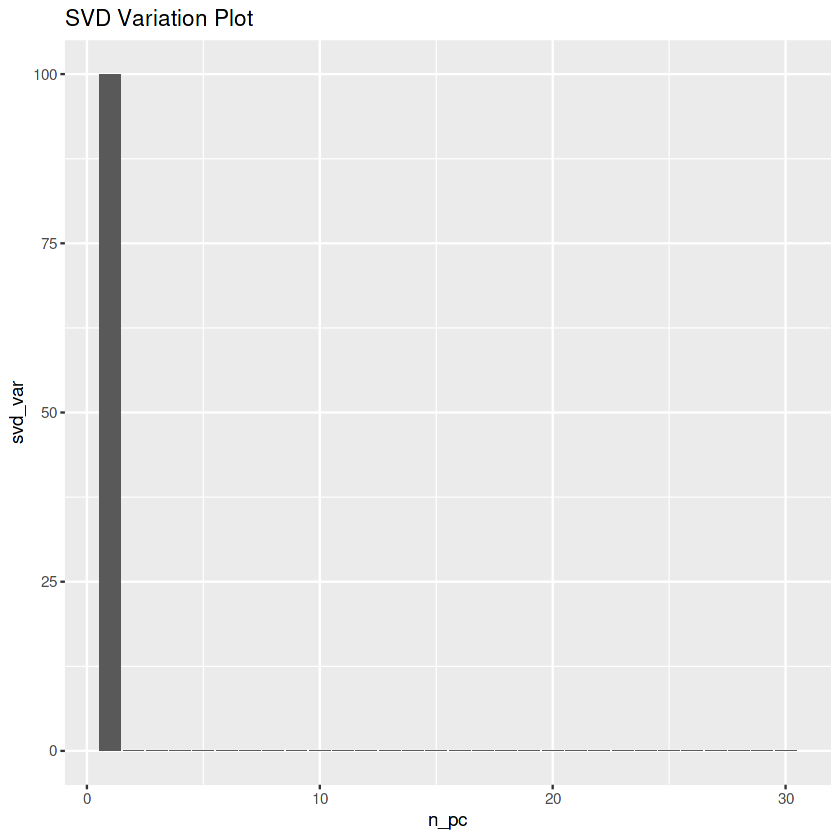

In [28]:
svd <- svd(X)

# Calculate Explained Variance
svd_var <- round(svd$d^2/sum(svd$d^2) * 100, 4) 
n_pc <- seq(1, length(svd_var))
svd_df <- as.data.frame(svd_var, n_pc)

# Graph of explained variance
svd_df %>% 
  ggplot(aes(x = n_pc, y = svd_var)) +
    geom_bar(stat = 'identity') +
    labs(title = "SVD Variation Plot",
         xlab = "PCs",
         ylab = "Prop. of variance explained",
         ylim = c(0, 100))

**Takeaway:** Beyond 5 principal components, there is very little improvement in the explained variance for PCA while the first column explained the majority of the variance using SVD. We will move forward with the reduced dataframe from PCA proving more stable.

In [29]:
# Consolodiating PCA transformed dataframe
X_pca <- as.data.frame(pca$x[, 1:5])
y <- subset(df, select = c(Class))
df_pca <- cbind(X_pca, y)

In [30]:
# Partitioning train-test split
index <- createDataPartition(y = df_pca$Class, p = .7, 
                             times = 1, list = FALSE)
train <- df_pca[index,]
test  <- df_pca[-index,]

In [31]:
# K-fold cross validation
kfold_cv <- trainControl(method = "cv",  number = 3, 
                        savePredictions = T)

# 9. Machine Learning - Simple Models

This section will leverage the powerful sci-kit-learn package to build multiple models with little to no parameter tuning for comparison. We will only use the cross-validation error on our training dataset to avoid any data leakage.

**Definition:** Logistic Regression is a predictive classifier that models an S-shaped curve (Sigmoid function) on the data to label the examples. Further information [here](https://machinelearningmastery.com/logistic-regression-for-machine-learning/).

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


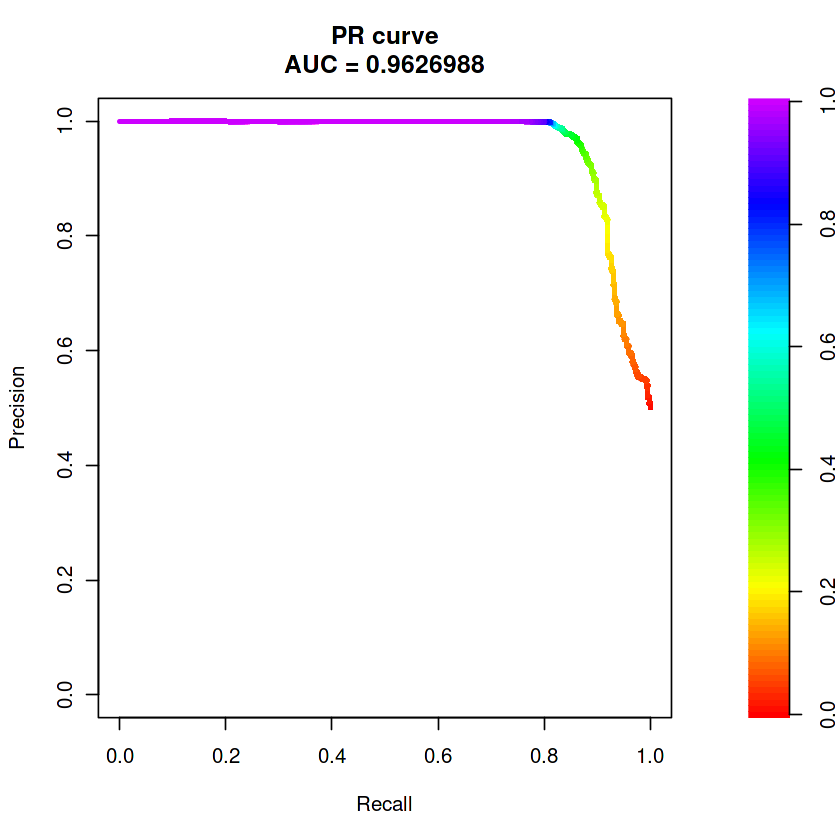

In [32]:
logreg_model <- train(form=Class~., data = train,
               method="glm", family="binomial",
               trControl=kfold_cv, tuneLength=3)

preds <- predict(logreg_model, train, type="prob")[,2] #prob of positive class
preds_pos <- preds[train[,6]==1] #preds for true positive class
preds_neg <- preds[train[,6]==0] #preds for true negative class

PRC <- pr.curve(preds_pos, preds_neg, curve=TRUE)
plot(PRC)

**Definition:** A Decision Tree is a supervised machine learning algorithm building an actual tree based on splits within the data [here](https://www.xoriant.com/blog/product-engineering/decision-trees-machine-learning-algorithm.html).

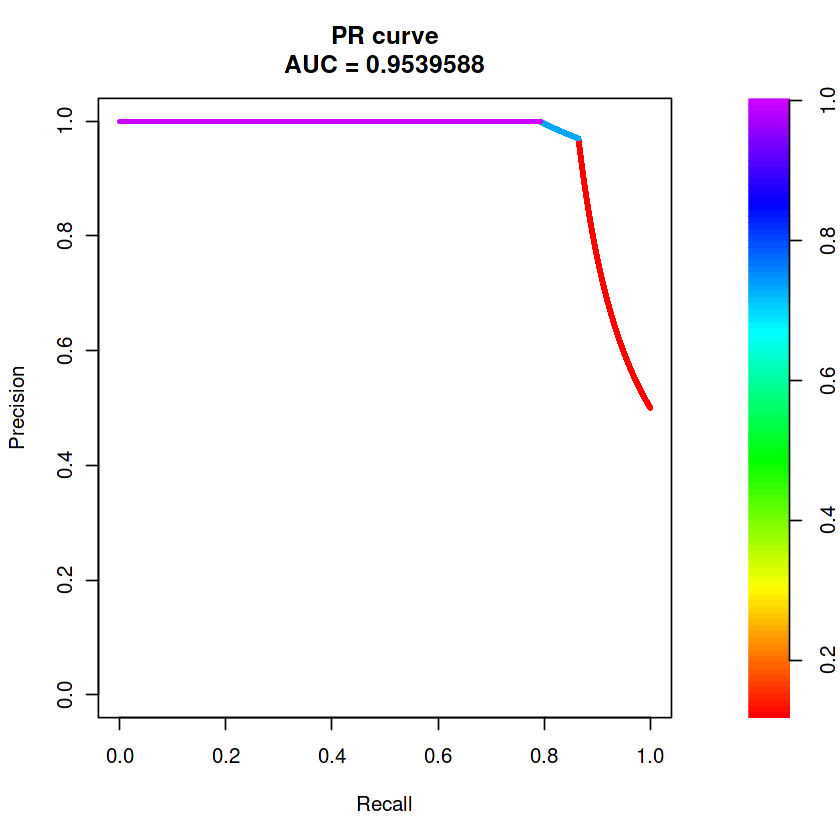

In [33]:
tree_model <- train(form=Class~., data = train,
               method="rpart", 
               trControl=kfold_cv, tuneLength=3)
preds <- predict(tree_model, train, type="prob")[,2] #prob of positive class
preds_pos <- preds[train[,6]==1] #preds for true positive class
preds_neg <- preds[train[,6]==0] #preds for true negative class

PRC <- pr.curve(preds_pos, preds_neg, curve=TRUE)
plot(PRC)

**Takeaway:** Our best model is the Logistic regression at 96.3% AUPRC.

# 10. Model Performance Evaluation

This section will build on everything we've done throughout this notebook and evaluate the best model using AUPRC.

**Definition:** AUPRC (Area Under the Precision-Recall Curve) focuses on finding the positive examples; in other words, the fraudulent transactions in our case. Further information [here](https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/).

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


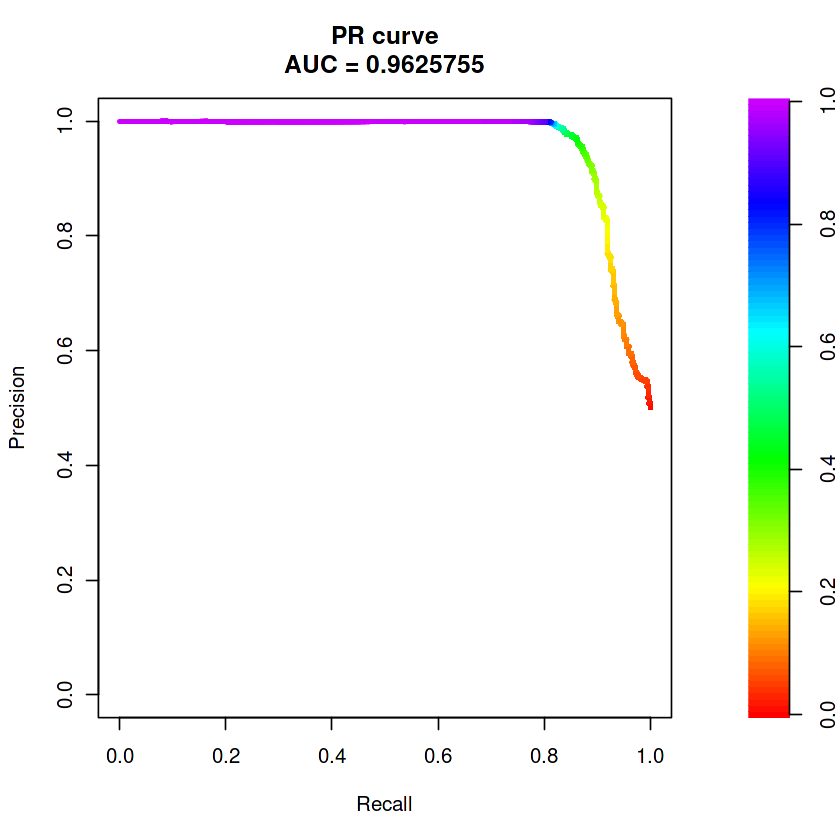

In [34]:
logreg_model <- train(form=Class~., data = train,
               method="glm", family="binomial",
               trControl=kfold_cv, tuneLength=3)

preds <- predict(logreg_model, test, type="prob")[,2] #prob of positive class
preds_pos <- preds[test[,6]==1] #preds for true positive class
preds_neg <- preds[test[,6]==0] #preds for true negative class

PRC <- pr.curve(preds_pos, preds_neg, curve=TRUE)
plot(PRC)

**Conclusion:** Given its simple implementation and recurrent high performance, we will present the Logistic Regression as our final model.